[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== 이벤트 이후 5거래일간 CAR (%) ===
피에스엠씨      9.402958
서희건설       2.472247
조광페인트      1.923517
에이엔피      -3.154646
유성티엔에스    -5.445817
바른손      -21.685160
우리들제약    -22.427397
dtype: float64


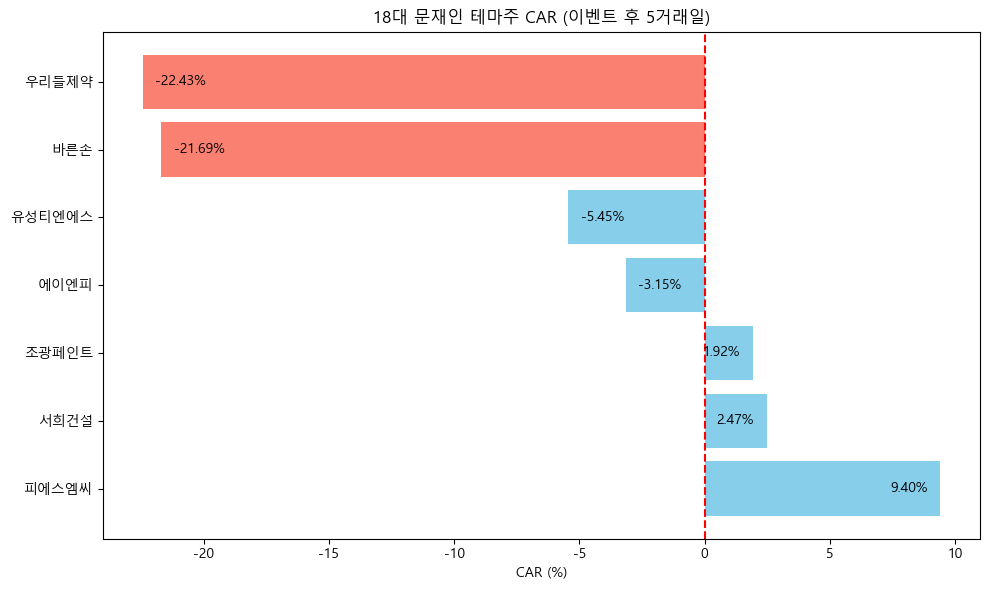

In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

event_date = '2012-12-19'
event_dt = pd.to_datetime(event_date)

estimation_days = 250
car_days = 5

# 수집 구간: event_date - 300일 ~ event_date + 5일
start_date = (event_dt - pd.Timedelta(days=estimation_days + 30)).strftime('%Y-%m-%d')
end_date = (event_dt + pd.Timedelta(days=car_days + 5)).strftime('%Y-%m-%d')

# 2. 분석 종목
tickers = {
    '우리들제약': '004720.KS',
    '에이엔피': '015260.KS',
    '피에스엠씨': '024850.KS',
    '바른손': '018700.KS',
    '유성티엔에스': '024800.KS',
    '서희건설': '035890.KS',
    '조광페인트': '004910.KS',
    'KODEX200': '069500.KS'
}

df = pd.DataFrame()
for name, code in tickers.items():
    df[name] = yf.download(code, start=start_date, end=end_date)['Close']
df.dropna(inplace=True)

log_returns = np.log(df / df.shift(1)).dropna()
market_return = log_returns['KODEX200']

# 5. 정상수익률 추정: event 이전 250거래일 기준
estimation_data = log_returns[log_returns.index < event_dt].tail(estimation_days)

# 6. 이벤트 이후 1~5거래일
event_window_data = log_returns[log_returns.index > event_dt].head(car_days)

# 7. 비정상수익률 및 CAR 계산
car_result = {}
for stock in tickers:
    if stock == 'KODEX200':
        continue

    y = estimation_data[stock]
    x = sm.add_constant(estimation_data['KODEX200'])
    model = sm.OLS(y, x).fit()

    x_event = sm.add_constant(event_window_data['KODEX200'])
    expected = model.predict(x_event)
    actual = event_window_data[stock]
    abnormal = actual - expected
    car = abnormal.sum() * 100  # %
    car_result[stock] = car

# 8. 결과 정리 및 출력
car_series = pd.Series(car_result).sort_values(ascending=False)
print("=== 이벤트 이후 5거래일간 CAR (%) ===")
print(car_series)

# 9. 시각화
plt.figure(figsize=(10, 6))

# 색상 조건: 절대값 20% 넘으면 'salmon', 아니면 'skyblue'
colors = ['salmon' if abs(x) > 20 else 'skyblue' for x in car_series.values]

bars = plt.barh(car_series.index, car_series.values, color=colors)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("18대 문재인 테마주 CAR (이벤트 후 5거래일)")
plt.xlabel("CAR (%)")

# 막대 끝에 값 표시
for bar in bars:
    width = bar.get_width()
    label_x = width - 0.5 if width > 0 else width + 0.5
    align = 'right' if width > 0 else 'left'
    plt.text(label_x, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}%', ha=align, va='center')

plt.tight_layout()
plt.show()



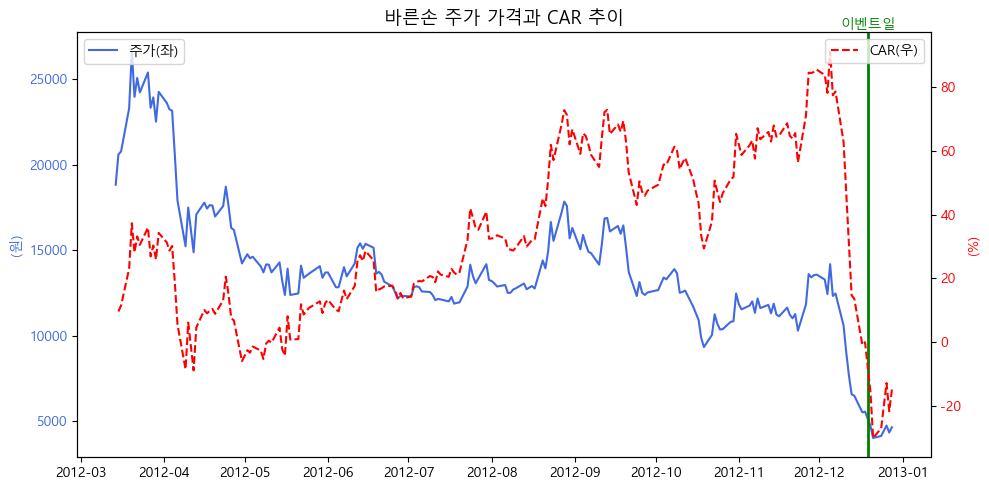

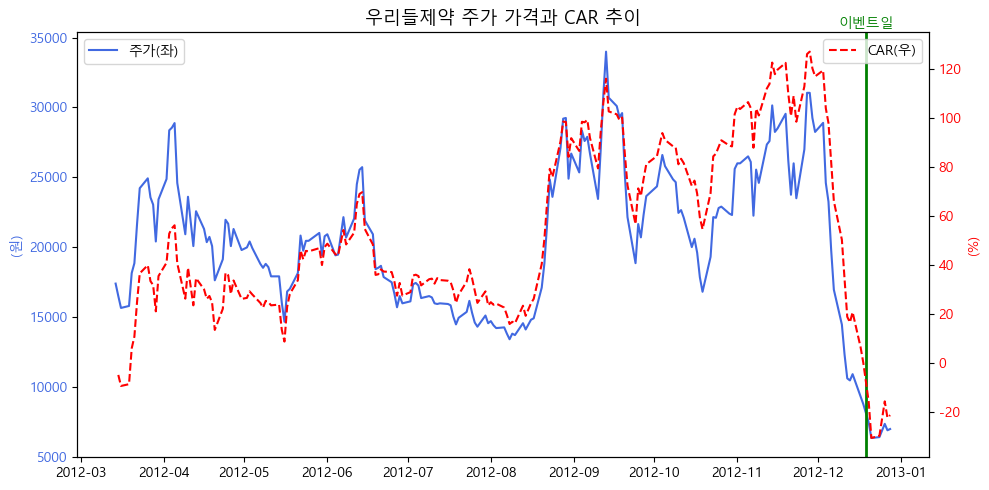

In [47]:
for stock in selected.index:
    abnormal_cumsum = abnormal_returns_dict[stock].cumsum() * 100
    price_series = df[stock]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # 좌측: 주가 (연한 파랑)
    ax1.plot(price_series, color='royalblue', label='주가(좌)')
    ax1.set_ylabel('(원)', color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')

    # 우측: CAR (빨강 실선)
    ax2.plot(abnormal_cumsum, color='red', linestyle='--', label='CAR(우)')
    ax2.set_ylabel('(%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 이벤트일 세로선 (굵은 초록색 실선)
    ax1.axvline(event_dt, color='green', linestyle='-', linewidth=2)

    # '이벤트일' 텍스트 표시
    ymax = price_series.max()
    ax1.annotate('이벤트일',
                 xy=(event_dt, ymax),
                 xytext=(event_dt, ymax * 1.05),
                 ha='center', color='green', fontsize=10)

    # 제목 및 범례
    plt.title(f"{stock} 주가 가격과 CAR 추이", fontsize=13)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
